In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.utils import resample

from collections import Counter

from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import MultiHeadAttention, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

#### 데이터셋 정리

In [2]:
# 1. 텍스트 임베딩 및 감정 라벨 불러오기
df_text = pd.read_csv(r'C:\project_files\Multimodal_Auto _BGM_Addition_System\dataset_preprocessed\text\text_embeddings_with_labels_kobert.csv')
text_embeddings = df_text.iloc[:, :-1].values  # 텍스트 임베딩 (768차원)
text_labels = df_text['emotion_label'].values  # 감정 라벨

# 2. 이미지 임베딩 및 감정 라벨 불러오기
df_image = pd.read_csv(r'C:\project_files\Multimodal_Auto _BGM_Addition_System\final_code\final_resnet50_emotion_classifier_embeddings_image.csv')
image_embeddings = df_image.iloc[:, :-1].values  # 이미지 임베딩 (768차원)
image_labels = df_image['emotion_label'].values  # 감정 라벨

# 3. 오디오 임베딩 및 감정 라벨 불러오기
df_audio = pd.read_csv(r'C:\project_files\Multimodal_Auto _BGM_Addition_System\final_code\vatt_audio_features_encoded.csv')
audio_embeddings = df_audio.iloc[:, 1:-1].values  # 오디오 임베딩 (768차원)
audio_labels = df_audio['emotion_label'].values  # 감정 라벨

# 4. 비디오 임베딩 및 감정 라벨 불러오기
df_video = pd.read_csv(r'C:\project_files\Multimodal_Auto _BGM_Addition_System\final_code\video_embeddings_with_labels_768.csv')
video_embeddings = df_video.iloc[:, 2:-1].values  # 비디오 임베딩 (768차원)
video_labels = df_video['emotion_label'].values  # 감정 라벨

# 5. Keras 모델의 입력 레이어 정의
text_input = layers.Input(shape=(text_embeddings.shape[1],), name="text_input")
image_input = layers.Input(shape=(image_embeddings.shape[1],), name="image_input")
audio_input = layers.Input(shape=(audio_embeddings.shape[1],), name="audio_input")
video_input = layers.Input(shape=(video_embeddings.shape[1],), name="video_input")

# 출력 확인
print(f"Text input shape: {text_input.shape}")
print(f"Image input shape: {image_input.shape}")
print(f"Audio input shape: {audio_input.shape}")
print(f"Video input shape: {video_input.shape}")


Text input shape: (None, 768)
Image input shape: (None, 768)
Audio input shape: (None, 768)
Video input shape: (None, 768)


In [3]:
# 중복 확인 함수
def check_duplicates(data, modality_name):
    data_tuples = list(map(tuple, data))  # numpy 배열을 튜플로 변환
    unique_data = set(data_tuples)  # 고유 값만 유지
    duplicates_count = len(data_tuples) - len(unique_data)
    print(f"{modality_name} Data Duplicates: {duplicates_count}")

# 각 모달리티에 대해 중복 확인
check_duplicates(text_embeddings, "Text")
check_duplicates(image_embeddings, "Image")
check_duplicates(audio_embeddings, "Audio")
check_duplicates(video_embeddings, "Video")


Text Data Duplicates: 54908
Image Data Duplicates: 0
Audio Data Duplicates: 0
Video Data Duplicates: 0


In [4]:
# 중복된 레이블 제거 함수
def remove_duplicates_with_labels(embeddings, labels, modality_name):

    # 임베딩과 레이블을 함께 묶음
    data_with_labels = list(zip(map(tuple, embeddings), labels))  # (임베딩, 레이블) 튜플로 묶음
    unique_data_with_labels = list(set(data_with_labels))  # 중복 제거

    # 분리
    unique_embeddings, unique_labels = zip(*unique_data_with_labels)

    print(f"{modality_name} Data Before Removing Duplicates: {len(embeddings)}")
    print(f"{modality_name} Data After Removing Duplicates: {len(unique_embeddings)}")

    return np.array(unique_embeddings), np.array(unique_labels)


# 각 모달리티에서 중복 제거
text_embeddings, text_labels = remove_duplicates_with_labels(text_embeddings, text_labels, "Text")
image_embeddings, image_labels = remove_duplicates_with_labels(image_embeddings, image_labels, "Image")
audio_embeddings, audio_labels = remove_duplicates_with_labels(audio_embeddings, audio_labels, "Audio")
video_embeddings, video_labels = remove_duplicates_with_labels(video_embeddings, video_labels, "Video")


Text Data Before Removing Duplicates: 103849
Text Data After Removing Duplicates: 56859
Image Data Before Removing Duplicates: 16341
Image Data After Removing Duplicates: 16341
Audio Data Before Removing Duplicates: 40713
Audio Data After Removing Duplicates: 40713
Video Data Before Removing Duplicates: 235439
Video Data After Removing Duplicates: 235439


In [5]:
# 감정 레이블 분포 확인 함수
def plot_label_distribution(labels, title):
    label_counts = Counter(labels)
    print(f"{title} Label Distribution: {label_counts}")


# 각 모달리티 감정 레이블 분포 확인
plot_label_distribution(text_labels, "Text Labels")
plot_label_distribution(image_labels, "Image Labels")
plot_label_distribution(audio_labels, "Audio Labels")
plot_label_distribution(video_labels, "Video Labels")


Text Labels Label Distribution: Counter({0: 11759, 5: 10317, 4: 9609, 1: 9164, 2: 8802, 3: 7208})
Image Labels Label Distribution: Counter({0: 3120, 2: 2663, 3: 2663, 1: 2652, 4: 2627, 5: 2616})
Audio Labels Label Distribution: Counter({4: 13986, 0: 11633, 1: 4660, 3: 4548, 2: 4131, 5: 1755})
Video Labels Label Distribution: Counter({1: 73085, 3: 49782, 0: 41708, 4: 35241, 5: 24027, 2: 11596})


In [6]:
# 레이블 분포
text_label_counts = Counter(text_labels)
image_label_counts = Counter(image_labels)
audio_label_counts = Counter(audio_labels)
video_label_counts = Counter(video_labels)

# 클래스별 최소 샘플 수 계산
class_labels = set(text_label_counts.keys()) & set(image_label_counts.keys()) & set(audio_label_counts.keys()) & set(video_label_counts.keys())
min_samples_per_class = {label: min(
    text_label_counts[label], 
    image_label_counts[label], 
    audio_label_counts[label], 
    video_label_counts[label]
) for label in class_labels}

print(f"Minimum samples per class: {min_samples_per_class}")


Minimum samples per class: {0: 3120, 1: 2652, 2: 2663, 3: 2663, 4: 2627, 5: 1755}


In [7]:
# 데이터프레임 생성
text_data = pd.DataFrame({'label': text_labels, 'embedding': list(text_embeddings)})
image_data = pd.DataFrame({'label': image_labels, 'embedding': list(image_embeddings)})
audio_data = pd.DataFrame({'label': audio_labels, 'embedding': list(audio_embeddings)})
video_data = pd.DataFrame({'label': video_labels, 'embedding': list(video_embeddings)})

# 각 클래스에서 최소 샘플 수로 샘플링
balanced_text = text_data.groupby('label').apply(lambda x: x.sample(n=min_samples_per_class[x.name], random_state=42)).reset_index(drop=True)
balanced_image = image_data.groupby('label').apply(lambda x: x.sample(n=min_samples_per_class[x.name], random_state=42)).reset_index(drop=True)
balanced_audio = audio_data.groupby('label').apply(lambda x: x.sample(n=min_samples_per_class[x.name], random_state=42)).reset_index(drop=True)
balanced_video = video_data.groupby('label').apply(lambda x: x.sample(n=min_samples_per_class[x.name], random_state=42)).reset_index(drop=True)


In [8]:
# 샘플 수 확인
assert len(balanced_text) == len(balanced_image) == len(balanced_audio) == len(balanced_video)

# 데이터 분리
text_embeddings_balanced = np.stack(balanced_text['embedding'])
image_embeddings_balanced = np.stack(balanced_image['embedding'])
audio_embeddings_balanced = np.stack(balanced_audio['embedding'])
video_embeddings_balanced = np.stack(balanced_video['embedding'])
emotion_labels_balanced = balanced_text['label'].values  # 동일한 라벨 사용


In [9]:
# 데이터를 하나로 묶기
all_data_df = pd.DataFrame({
    "text": list(map(tuple, text_embeddings_balanced)),  # 텍스트 데이터 (튜플로 변환)
    "image": list(map(tuple, image_embeddings_balanced)),  # 이미지 데이터
    "audio": list(map(tuple, audio_embeddings_balanced)),  # 오디오 데이터
    "video": list(map(tuple, video_embeddings_balanced)),  # 비디오 데이터
    "label": emotion_labels_balanced  # 감정 라벨
})


In [10]:
# 모든 데이터를 하나로 묶기
all_data = list(zip(
    text_embeddings_balanced,
    image_embeddings_balanced,
    audio_embeddings_balanced,
    video_embeddings_balanced,
    emotion_labels_balanced
))

# 학습/테스트 데이터 분리
train_data, test_data = train_test_split(
    all_data,
    test_size=0.2,  # 테스트 데이터 비율
    random_state=42,  # 재현 가능성을 위한 시드
    stratify=emotion_labels_balanced  # 감정 레이블 분포 유지
)

# 분리된 데이터를 각 모달리티 및 레이블로 다시 나누기
text_train, image_train, audio_train, video_train, y_train = zip(*train_data)
text_test, image_test, audio_test, video_test, y_test = zip(*test_data)

# numpy 배열로 변환
text_train = np.array(text_train)
image_train = np.array(image_train)
audio_train = np.array(audio_train)
video_train = np.array(video_train)
y_train = np.array(y_train)

text_test = np.array(text_test)
image_test = np.array(image_test)
audio_test = np.array(audio_test)
video_test = np.array(video_test)
y_test = np.array(y_test)

# 데이터 크기 확인
print(f"Train Text embeddings shape: {text_train.shape}")
print(f"Test Text embeddings shape: {text_test.shape}")
print(f"Train Emotion labels shape: {y_train.shape}")
print(f"Test Emotion labels shape: {y_test.shape}")

# 중복 확인 함수
def check_overlap(train_text, train_image, train_audio, train_video, train_labels, 
                  test_text, test_image, test_audio, test_video, test_labels):
    """
    트레인과 테스트 데이터에서 중복 확인
    """
    # 튜플로 변환하여 해시 가능하게 만듦
    train_set = set(zip(
        map(tuple, train_text),
        map(tuple, train_image),
        map(tuple, train_audio),
        map(tuple, train_video),
        train_labels
    ))
    test_set = set(zip(
        map(tuple, test_text),
        map(tuple, test_image),
        map(tuple, test_audio),
        map(tuple, test_video),
        test_labels
    ))

    # 교집합 확인
    overlap = train_set.intersection(test_set)
    print(f"Number of overlapping samples between train and test sets: {len(overlap)}")
    return overlap



Train Text embeddings shape: (12384, 768)
Test Text embeddings shape: (3096, 768)
Train Emotion labels shape: (12384,)
Test Emotion labels shape: (3096,)


#### 학습

In [11]:
# 데이터 정규화
text_embeddings = normalize(text_embeddings, norm='l2')
image_embeddings = normalize(image_embeddings, norm='l2')
audio_embeddings = normalize(audio_embeddings, norm='l2')
video_embeddings = normalize(video_embeddings, norm='l2')

# 텍스트 입력
text_input = layers.Input(shape=(768,), name="text_input")
text_x = layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.001))(text_input)
text_x = layers.BatchNormalization()(text_x)
text_x = layers.Dropout(0.4)(text_x)

# 이미지 입력
image_input = layers.Input(shape=(768,), name="image_input")
image_x = layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.001))(image_input)
image_x = layers.BatchNormalization()(image_x)
image_x = layers.Dropout(0.4)(image_x)

# 오디오 입력
audio_input = layers.Input(shape=(768,), name="audio_input")
audio_x = layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.001))(audio_input)
audio_x = layers.BatchNormalization()(audio_x)
audio_x = layers.Dropout(0.4)(audio_x)

# 비디오 입력
video_input = layers.Input(shape=(768,), name="video_input")
video_x = layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.001))(video_input)
video_x = layers.BatchNormalization()(video_x)
video_x = layers.Dropout(0.4)(video_x)

# 모달 간 상호작용 강화 (CrossAttention Layer 추가)
merged_features = layers.Concatenate()([text_x, image_x, audio_x, video_x])
merged_features = layers.Reshape((4, 512))(merged_features)
attention_output = MultiHeadAttention(num_heads=8, key_dim=64)(merged_features, merged_features)
attention_output = layers.Flatten()(attention_output)

# Fully Connected Layer
x = layers.Dense(256, activation="relu", kernel_initializer=HeNormal(), kernel_regularizer=regularizers.l2(0.001))(attention_output)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(128, activation="relu", kernel_initializer=HeNormal(), kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

output = layers.Dense(6, activation="softmax")(x)

# 모델 정의
vatt_model = models.Model(inputs=[text_input, image_input, audio_input, video_input], outputs=output)

# 모델 컴파일 (AdamW 사용)
vatt_model.compile(optimizer=Adam(learning_rate=1e-4),
                   loss="categorical_crossentropy",
                   metrics=["accuracy"])

# 모델 요약
vatt_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 768)]        0           []                               
                                                                                                  
 image_input (InputLayer)       [(None, 768)]        0           []                               
                                                                                                  
 audio_input (InputLayer)       [(None, 768)]        0           []                               
                                                                                                  
 video_input (InputLayer)       [(None, 768)]        0           []                               
                                                                                              

In [12]:
# 1. 각 모달리티의 데이터 개수 확인
num_text_samples = text_embeddings.shape[0]
num_audio_samples = audio_embeddings.shape[0]
num_image_samples = image_embeddings.shape[0]
num_video_samples = video_embeddings.shape[0]


print(f"Text data - Train: {text_embeddings.shape[0]}")
print(f"Audio data - Train: {audio_embeddings.shape[0]}")
print(f"Image data - Train: {image_embeddings.shape[0]}")
print(f"Video data - Train: {video_embeddings.shape[0]}")
print("----------------------")

# 2. 데이터의 최대 크기에 맞추기 (여기서는 4500으로 설정)
max_samples = 235439

# 3. 각 모달리티 데이터 반복(resampling)하여 최대 샘플 수로 맞추기
text_embeddings_balanced = resample(text_embeddings, n_samples=max_samples, random_state=42, replace=True)
text_labels_balanced = resample(text_labels, n_samples=max_samples, random_state=42, replace=True)

audio_embeddings_balanced = resample(audio_embeddings, n_samples=max_samples, random_state=42, replace=True)
audio_labels_balanced = resample(audio_labels, n_samples=max_samples, random_state=42, replace=True)

image_embeddings_balanced = resample(image_embeddings, n_samples=max_samples, random_state=42, replace=True)
image_labels_balanced = resample(image_labels, n_samples=max_samples, random_state=42, replace=True)

video_embeddings_balanced = resample(video_embeddings, n_samples=max_samples, random_state=42, replace=True)
video_labels_balanced = resample(video_labels, n_samples=max_samples, random_state=42, replace=True)

# 4. 학습 및 테스트 데이터 분할
x_train_text, x_test_text, x_train_audio, x_test_audio, x_train_image, x_test_image, x_train_video, x_test_video, y_train, y_test = train_test_split(
    text_embeddings_balanced, audio_embeddings_balanced, image_embeddings_balanced, video_embeddings_balanced, 
    text_labels_balanced, test_size=0.2, random_state=42
)

# 5. 감정 라벨을 one-hot encoding으로 변환
y_train = to_categorical(y_train, num_classes=6)
y_test = to_categorical(y_test, num_classes=6)

# 각 데이터의 샘플 수 확인
print(f"Text data - Train: {x_train_text.shape[0]}, Test: {x_test_text.shape[0]}")
print(f"Audio data - Train: {x_train_audio.shape[0]}, Test: {x_test_audio.shape[0]}")
print(f"Image data - Train: {x_train_image.shape[0]}, Test: {x_test_image.shape[0]}")
print(f"Video data - Train: {x_train_video.shape[0]}, Test: {x_test_video.shape[0]}")


Text data - Train: 56859
Audio data - Train: 40713
Image data - Train: 16341
Video data - Train: 235439
----------------------
Text data - Train: 188351, Test: 47088
Audio data - Train: 188351, Test: 47088
Image data - Train: 188351, Test: 47088
Video data - Train: 188351, Test: 47088


In [13]:
# 감정 라벨 분할
x_train_text, x_test_text, x_train_audio, x_test_audio, x_train_image, x_test_image, x_train_video, x_test_video, y_train, y_test = train_test_split(
    text_embeddings_balanced, audio_embeddings_balanced, image_embeddings_balanced, video_embeddings_balanced, 
    text_labels_balanced, test_size=0.2, random_state=42
)

# 감정 레이블을 one-hot encoding으로 변환
y_train = to_categorical(y_train, num_classes=6)
y_test = to_categorical(y_test, num_classes=6)

# 원-핫 레이블을 정수형으로 변환
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# 학습 데이터 라벨 비율 확인
train_label_counts = Counter(y_train_labels)
test_label_counts = Counter(y_test_labels)

# 전체 샘플 수 계산
total_train_samples = len(y_train_labels)
total_test_samples = len(y_test_labels)

# 비율 계산 및 출력
print("=== 학습 데이터 감정 라벨 비율 ===")
for label, count in train_label_counts.items():
    print(f"라벨 {label}: {count}개 ({count / total_train_samples * 100:.2f}%)")

print("\n=== 테스트 데이터 감정 라벨 비율 ===")
for label, count in test_label_counts.items():
    print(f"라벨 {label}: {count}개 ({count / total_test_samples * 100:.2f}%)")


=== 학습 데이터 감정 라벨 비율 ===
라벨 3: 23868개 (12.67%)
라벨 0: 38632개 (20.51%)
라벨 2: 29096개 (15.45%)
라벨 4: 31893개 (16.93%)
라벨 1: 30449개 (16.17%)
라벨 5: 34413개 (18.27%)

=== 테스트 데이터 감정 라벨 비율 ===
라벨 4: 7903개 (16.78%)
라벨 2: 7282개 (15.46%)
라벨 1: 7600개 (16.14%)
라벨 0: 9798개 (20.81%)
라벨 3: 5925개 (12.58%)
라벨 5: 8580개 (18.22%)


In [14]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # 검증 손실을 기준으로 학습률 조정
    factor=0.5,          # 학습률을 50% 감소
    patience=10,         # 10 에포크 동안 개선이 없으면 학습률 감소
    min_lr=1e-6          # 최소 학습률
)


In [15]:
# Cosine Annealing 학습률 스케줄링 함수 정의
def cosine_annealing(epoch):
    lr_min = 1e-6  # 최소 학습률
    lr_max = 1e-3  # 최대 학습률
    total_epochs = 60  # 전체 학습 에포크 수
    return lr_min + 0.5 * (lr_max - lr_min) * (1 + math.cos(epoch / total_epochs * math.pi))

# LearningRateScheduler 콜백 생성
lr_scheduler = LearningRateScheduler(cosine_annealing)

# 모델 훈련
history = vatt_model.fit(
    [x_train_text, x_train_image, x_train_audio, x_train_video],  # 멀티모달 입력
    y_train,
    epochs=60,
    batch_size=16,
    validation_data=([x_test_text, x_test_image, x_test_audio, x_test_video], y_test),
    callbacks=[lr_scheduler]  # reduce_lr 제거
)


Epoch 1/60
11772/11772 [==============================] - 70s 6ms/step - loss: 2.0577 - accuracy: 0.1919 - val_loss: 1.8308 - val_accuracy: 0.2108 - lr: 0.0010
Epoch 2/60
11772/11772 [==============================] - 71s 6ms/step - loss: 1.8401 - accuracy: 0.2065 - val_loss: 1.8169 - val_accuracy: 0.2127 - lr: 9.9932e-04
Epoch 3/60
11772/11772 [==============================] - 69s 6ms/step - loss: 1.8469 - accuracy: 0.2072 - val_loss: 1.8418 - val_accuracy: 0.2087 - lr: 9.9726e-04
Epoch 4/60
11772/11772 [==============================] - 69s 6ms/step - loss: 1.8433 - accuracy: 0.2075 - val_loss: 1.8681 - val_accuracy: 0.2106 - lr: 9.9385e-04
Epoch 5/60
11772/11772 [==============================] - 69s 6ms/step - loss: 1.8480 - accuracy: 0.2092 - val_loss: 1.8424 - val_accuracy: 0.2149 - lr: 9.8908e-04
Epoch 6/60
11772/11772 [==============================] - 69s 6ms/step - loss: 1.8522 - accuracy: 0.2085 - val_loss: 1.8452 - val_accuracy: 0.2181 - lr: 9.8298e-04
Epoch 7/60
11772/117

In [16]:
# 테스트 데이터로 모델 성능 평가
test_loss, test_accuracy = vatt_model.evaluate(
    [x_test_text, x_test_image, x_test_audio, x_test_video],  # 4개의 모달리티 입력
    y_test  # 레이블
)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


1472/1472 [==============================] - 3s 2ms/step - loss: 1.7244 - accuracy: 0.2547
Test Loss: 1.7243739366531372
Test Accuracy: 0.25465086102485657


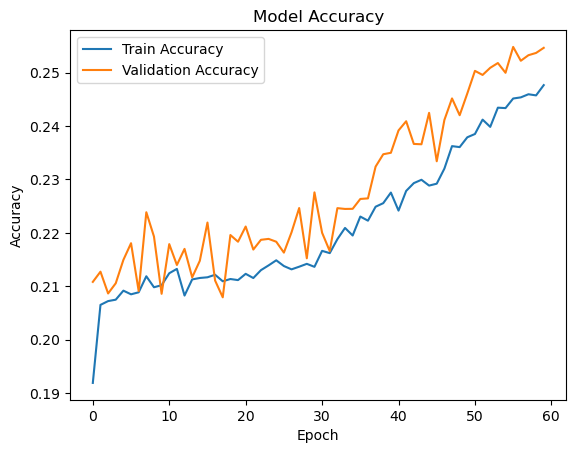

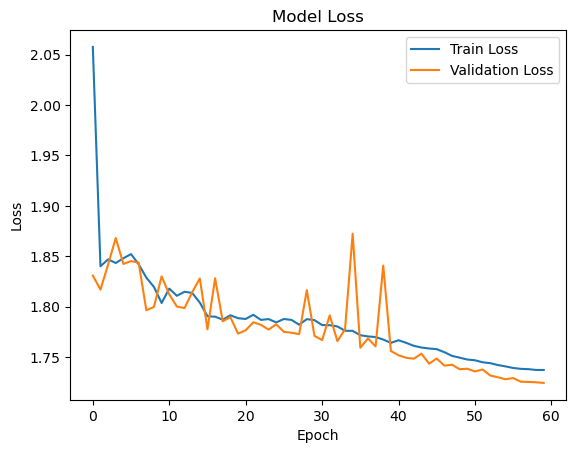

In [17]:
# 4. 학습 과정 시각화

# 학습 정확도 및 손실 그래프 그리기
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# HDF5 형식으로 저장
vatt_model.save(r"C:\project_files\Multimodal_Auto _BGM_Addition_System\final_code/vatt_model.h5")


#### 모델을 사용하여 예측

- 인풋은 각 모달리티당 768차원으로 임베딩된 형식으로 함

인풋이 이미지인 경우

In [ ]:
# 1. ResNet50 모델 로드 및 차원 축소 모델 정의
resnet_model = ResNet50(weights="imagenet", include_top=False, pooling="avg")

# ResNet50 임베딩 크기를 768로 변환
image_embedding_input = Input(shape=(2048,))
reduced_image_embedding = Dense(768, activation="relu")(image_embedding_input)
reduction_model = Model(inputs=image_embedding_input, outputs=reduced_image_embedding)

# 2. 이미지 전처리 및 임베딩 생성
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))  # ResNet50 입력 크기
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # 배치 차원 추가
    img_array = preprocess_input(img_array)  # ResNet50 전처리
    return img_array

def generate_image_embedding(image_path):
    img_array = preprocess_image(image_path)
    embedding = resnet_model.predict(img_array)  # (1, 2048)
    reduced_embedding = reduction_model.predict(embedding)  # (1, 768)
    return reduced_embedding

# 3. 더미 데이터 생성
def generate_dummy_data():
    dummy_text = np.zeros((1, 768)) 
    dummy_audio = np.zeros((1, 768)) 
    dummy_video = np.zeros((1, 768)) 
    return dummy_text, dummy_audio, dummy_video

# 4. 예측 수행 함수
def predict_emotion(image_path, model):
    # 이미지 임베딩 생성
    image_embedding = generate_image_embedding(image_path)

    # 더미 데이터 생성
    dummy_text, dummy_audio, dummy_video = generate_dummy_data()

    # 모델 입력 준비
    X_input = [dummy_text, image_embedding, dummy_audio, dummy_video]

    # 예측 수행 (training=False 추가)
    prediction = model(X_input, training=False).numpy()
    predicted_class = prediction.argmax(axis=1)

    return prediction, predicted_class

# 예측 시 로드
cross_model = tf.keras.models.load_model("vatt_model.h5", compile=True)


# 5. 감정 예측 테스트
if __name__ == "__main__":
    test_image_path = r"C:\project_files\Multimodal_Auto _BGM_Addition_System\dataset\image\EmotionROI\images\joy\7.jpg"
    prediction, predicted_class = predict_emotion(test_image_path, cross_model)
    print(f"Predicted Probabilities: {prediction}")
    print(f"Predicted Class (Emotion): {predicted_class[0]}")


In [ ]:
# emotion_label_mapping = {'anger': 0, 'disgust': 1, 'fear': 2, 'joy': 3, 'sad': 4, 'surprise': 5}

인풋이 각 모달의 임베딩인 경우

In [ ]:
# 예측에 사용할 샘플 데이터 (테스트 데이터에서 하나의 샘플 선택)
sample_text = x_test_text[40].reshape(1, -1)  # 텍스트 임베딩 (배치 차원 추가)
sample_image = x_test_image[40].reshape(1, -1)  # 이미지 임베딩
sample_audio = x_test_audio[40].reshape(1, -1)  # 오디오 임베딩
sample_video = x_test_video[40].reshape(1, -1)  # 비디오 임베딩

# 모델 예측 수행
prediction = vatt_model.predict([sample_text, sample_image, sample_audio, sample_video])

# 예측 결과 출력
print("Raw prediction (probabilities):", prediction)
predicted_class = prediction.argmax(axis=-1)  # 가장 높은 확률의 클래스 선택
print("Predicted class:", predicted_class)
